# [Part 2] Predicting U.S. Electricity Consumption: Extended Feature Modeling
### Improving the predictive power

### **[Project Summary]**
  - **Research Question**: \
  Can predictive accuracy of U.S. electricity consumption be improved by adding features other than weather and seasonality, and which nonparametric model performs best?
  - **Goal**: \
  Improve prediction accuracy by expanding the feature beyond weather and seasonal features and evaluate which nonparametric model performs best with the extended features.
  - **Data**: \
  Same data as part 1, with additional feature engineering applied.
  - **Key Results**:
    - $R^2$ increased by about 46%, meaning the model explains significantly more variation in electricity consumption after adding the new features.
    - RMSE decreased about 79%, indicating that the predictions became much more accurate with the extended feature set.
  - **Tech Stack**: \
  Python, Pandas, Numpy, Scikit-learn (RandomForest, TimeSeriesSplit, RandomizedSearchCV),XGBoost, CatBoost, Metrics (RMSE, $R^2$), Matplotlib, Seaborn

- **Project Outline**
  1. Summary of Part 1 Results (Weather + sesaonal only)
  2. Expanded Feature & EDA
  3. RandomForest
  4. XGBoost
  5. CatBoost
  6. Model Comparison & Conclusion



# Imports & Load Data
Loaded the same dataset used in Part 1 to ensure consistency for comparison.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv("../data/processed/prediction_data.csv")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13248 entries, 0 to 13247
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  13248 non-null  int64  
 1   Month                 13248 non-null  int64  
 2   state                 13248 non-null  object 
 3   avg temp (F)          13248 non-null  float64
 4   precipitation (inch)  13248 non-null  float64
 5   PMDI                  13248 non-null  float64
 6   WindSpeed             13248 non-null  float64
 7   Megawatthours         13248 non-null  int64  
 8   season                13248 non-null  object 
 9   month_sin             13248 non-null  float64
 10  month_cos             13248 non-null  float64
 11  electricity (gwh)     13248 non-null  float64
dtypes: float64(7), int64(3), object(2)
memory usage: 1.2+ MB


# 1. Summary of Modeling Part 1. Interpretation
=> In part 1, only weather and seasonal features were used to predict electricity consumption.

| | Train RMSE | Test RMSE | $R^2$ |
| ----- | ----- | ----- | ----- |
| basic | 0.168 | 0.577 | 0.663 |
| tuned | 0.302 | 0.568 | 0.674 |

- The tuned model reduced overfitting, but a noticeable gap between train and test result still remained.
- $R^2$ stayed around 0.67, indicating the limitation of using only weather and seasonal features to explain electricity consumption.

# 2. Feature Engineering & Exploratory Data Analysis (EDA)
- Created lag features to capture temporal patterns in electricity consumption.
- Analyzed electricity consumption differences across states.
- Checked autocorrelation patterns for lag features.
- Examined relationships between lagged and current consumption.
- Analyzed correlations between all features including the target.

## 2.1. Lag 1 month & 12 months (Electricity Consumption)
Created 1 and 12 months lag features for each state to capture temporal dependencies in electricity consumption pattern.
- Lag 1: captures short term consumption patterns.
- Lag 12: captures yearly seasonal effects

In [ ]:
el1 = pd.read_csv("../data/raw/Monthly-States-Table RESIDENTIAL Sales (Consumption) 1990-2009.csv")
el2 = pd.read_csv("../data/raw/Monthly-States-Table RESIDENTIAL Sales (Consumption) 2010-2025.csv")

In [7]:
def electricity_preprocess(df):
  df = df[["Year","Month","State","Megawatthours"]].copy()
  df['Megawatthours'] = df["Megawatthours"].str.replace(',', '').astype(float)
  df['Megawatthours'] = df["Megawatthours"].astype(int)
  df = df.sort_values(by=["State", "Year","Month"]).reset_index()
  df = df.drop("index", axis=1)
  return df

In [8]:
el1 = electricity_preprocess(el1)
el2 = electricity_preprocess(el2)

In [9]:
df_2000 = pd.concat([el1, el2], axis=0, ignore_index=True)
df_2000 = df_2000[df_2000["Year"]==2000]
df_2000.loc[:, "electricity (gwh)"] = df_2000["Megawatthours"] * 0.001
df_2000 = df_2000.rename(columns={"State":"state"})
df_2000 = df_2000[~df_2000["state"].isin(["AK","HI"])]

In [10]:
data = pd.concat([df_2000, data], axis=0, ignore_index=True)

In [11]:
data["lag_1(gwh)"] = data.groupby("state")["electricity (gwh)"].shift(1)
data["lag_12(gwh)"] = data.groupby("state")["electricity (gwh)"].shift(12)

In [12]:
data = data[data["Year"]>2000].reset_index(drop=True)

## 2.2. Electricity Consumption by State
Compared residential electricity consumption across different states.

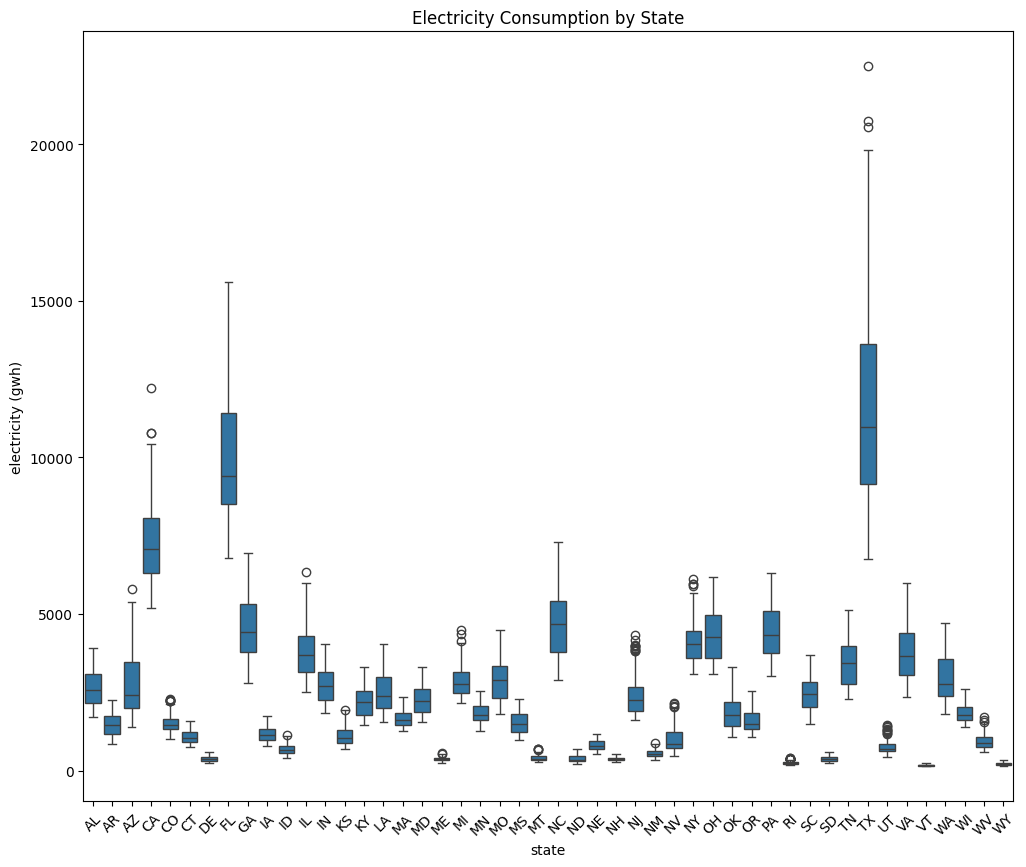

In [35]:
plt.figure(figsize=(12,10))
sns.boxplot(x="state", y="electricity (gwh)", data=data)
plt.xticks(rotation=45)
plt.title("Electricity Consumption by State")
plt.show()

**[Observation]**
- States such as California, Florida, and Texas show both higher consumption and greater variance.
- These differences reflect structural factors like population size, energy policies, and electricity price.
- Including the state feature helps the model learn different baseline consumption levels across states, which cannot be captured by weather or seasonal variables alone.

## 2.3. Autocorrelation and Lagged Consumption Relationships
- Examined the autocorrelation function to assess how past consumption influences future consumption.
- Checked scatter plots comparing lagged vs. current consumption.


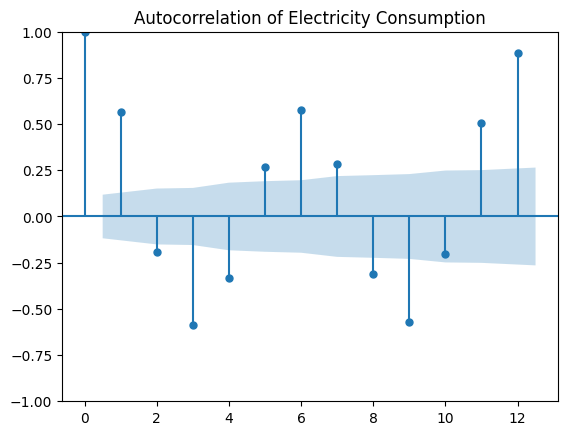

In [14]:
el_mean = data.groupby(["Year","Month"])["electricity (gwh)"].mean()
plot_acf(el_mean, lags = 12)
plt.title("Autocorrelation of Electricity Consumption")
plt.show()

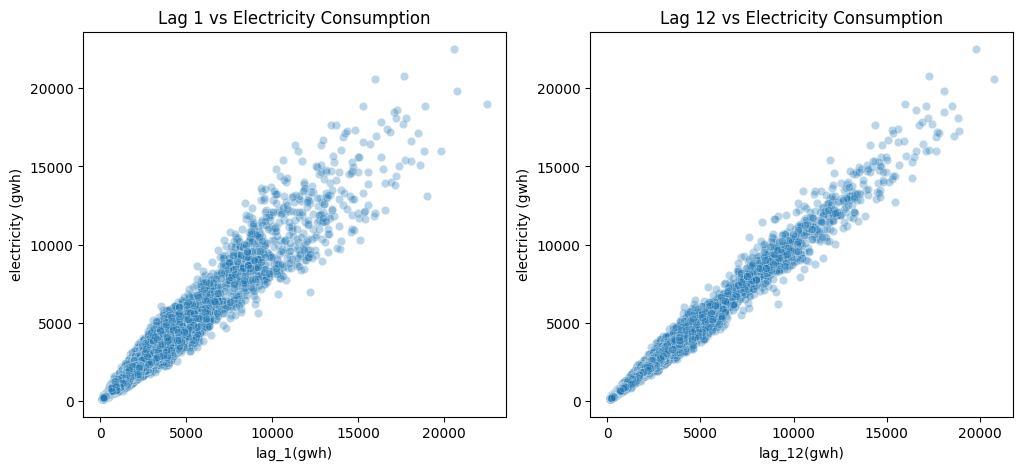

In [15]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.scatterplot(x="lag_1(gwh)", y="electricity (gwh)", data=data, alpha=0.3, ax=axes[0])
axes[0].set_title("Lag 1 vs Electricity Consumption")

sns.scatterplot(x="lag_12(gwh)", y="electricity (gwh)", data=data, alpha=0.3, ax=axes[1])
axes[1].set_title("Lag 12 vs Electricity Consumption")
plt.show()

**[Observation]**
- Both Lag 1 and lag 12 show strong autocorrelation and a clear positive relationship with current electricity consumption.
- This indicates that past consumption is a strong predictor of future consumption and should enhance model performance.

## 2.4. Correlation Analysis

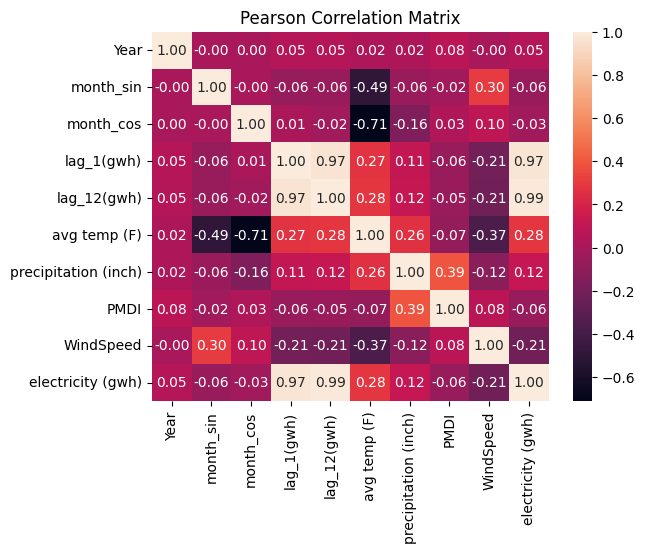

In [16]:
corr_p = data[["Year","month_sin","month_cos","lag_1(gwh)","lag_12(gwh)","avg temp (F)", "precipitation (inch)","PMDI","WindSpeed", "electricity (gwh)"]].corr()
sns.heatmap(corr_p, annot=True, fmt = ".2f")
plt.title("Pearson Correlation Matrix")
plt.show()

**[Observation]**
- Consistent with Part 1, weather features show weak linear correlations with electricity consumpton. However, this doesn't mean that they are not useful, since pearson correlation does not capture nonlinear relationships.
- Electricity consumption is highly correlated with its lagged values, indicating the importance of including lag features for prediction.


# 3. Modeling Part 2. Prediction
- In addition to weather and seasonal features, we now include state and lag features to better capture structural and temporal effects and improve predictive performance.
- We compare Random Forest, XGBoost, and Catboost to evaluate which model performs best with the extended feature set.

In [17]:
def metrics(true_y, pred_y):
  rmse = np.sqrt(mean_squared_error(true_y, pred_y))
  r2 = r2_score(true_y, pred_y)
  return rmse, r2

In [18]:
o_data = data.copy()
o_data = o_data.rename(columns={"electricity (gwh)": "electricity_gwh",
                                "avg temp (F)": "avg_temp_F",
                                "WindSpeed": "avg_wind_mph",
                                "lag_1(gwh)": "lag_1_gwh",
                                "lag_12(gwh)": "lag_12_gwh"})

In [19]:
train_2020 = o_data["Year"]<=2020
test_2021 = o_data["Year"]>=2021

## 3.1. RandomForest

RandomForest was used because it provides strong and stable predicitive performace and is robust across various datasets.
- One hot encoding
  - Applied to convert the state feature into numerical dummy variables.

### 3.1.1. Basic Model

Trained without any hyperparameter tuning. Only random_state=42 was set for reproducibility and fair comparison.

In [20]:
interpret = ["avg_temp_F", "avg_wind_mph", "precipitation (inch)", "PMDI", "month_sin", "month_cos"]
prediction = ["state","lag_1_gwh","lag_12_gwh"]
prediction += interpret
X= o_data[prediction]
y= o_data["electricity_gwh"]

X = pd.get_dummies(X, columns=["state"])

In [21]:
X_train, X_test = X[train_2020], X[test_2021]
y_train, y_test = y[train_2020], y[test_2021]

In [22]:
base_rf = RandomForestRegressor(random_state=42)
base_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [23]:
base_pred = base_rf.predict(X_test)
base_train_pred = base_rf.predict(X_train)

train_rmse, train_r2 = metrics(y_train, base_train_pred)
test_rmse, test_r2 = metrics(y_test, base_pred)
print(f"Train set RMSE without constraints: {train_rmse/y_train.std():.3f}")
print(f"Test set RMSE without constraints: {test_rmse/y_test.std():.3f}")
print(f"Test R^2: {test_r2:.3f}")

Train set RMSE without constraints: 0.038
Test set RMSE without constraints: 0.118
Test R^2: 0.986


### 3.1.2 Hyperparameter Tuning
- TimeSeriesSplit(n_splits=n)
  - It splits the data into n sequential train/validation sets, ensuring each split trains on past data and validates on future data to prevent data leakage.

- RandomizedSearchCV
  - Randomly tests a subset of hyperparameter combinations to identify the combination that produced the best RMSE.

In [24]:
cv_train_data = o_data[train_2020].sort_values(["Year","Month"])
time = cv_train_data[["Year", "Month"]].drop_duplicates().reset_index(drop=True)
tss = TimeSeriesSplit(n_splits=3)

param = {"max_depth": [5, 10, 15, 20],
         "n_estimators": [100,200,300,400,500],
         "max_features": ["sqrt","log2"],
         "min_samples_leaf": [3,5,7,10]}

fold = []
for train, test in tss.split(time):
  train_time = time.iloc[train]
  test_time = time.iloc[test]
  tr_fold = cv_train_data.merge(train_time, on = ["Year", "Month"])
  te_fold = cv_train_data.merge(test_time, on = ["Year", "Month"])
  fold.append((tr_fold.index, te_fold.index))

adv_rf = RandomForestRegressor(random_state=42)

rs = RandomizedSearchCV(adv_rf, param, n_iter = 30, cv=fold, scoring="neg_root_mean_squared_error",random_state=42,n_jobs=-1)
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=[(RangeIndex(start=0, stop=2880, step=1),
                        RangeIndex(start=0, stop=2880, step=1)),
                       (RangeIndex(start=0, stop=5760, step=1),
                        RangeIndex(start=0, stop=2880, step=1)),
                       (RangeIndex(start=0, stop=8640, step=1),
                        RangeIndex(start=0, stop=2880, step=1))],
                   estimator=RandomForestRegressor(random_state=42), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [3, 5, 7, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [25]:
rf_best = rs.best_estimator_
rf_best.fit(X_train, y_train)

best_pred = rf_best.predict(X_test)
best_rmse,best_r2 = metrics(y_test, best_pred)

rs_train_pred = rf_best.predict(X_train)
adv_train_rmse, adv_train_r2 = metrics(y_train, rs_train_pred)

print(f"Train set RMSE with constraints:  {adv_train_rmse/y_train.std():.3f}")
print(f"Test set RMSE with constraints:  {best_rmse/y_test.std():.3f}")
print(f"Test R^2: {best_r2:.3f}")

Train set RMSE with constraints:  0.087
Test set RMSE with constraints:  0.146
Test R^2: 0.979


### **[Random Forest Model Prediction]**
- Basic Model
  - train RMSE: 0.038 | test RMSE: 0.118 | test $R^2$: 0.986

- Tuned Model
  - train RMSE: 0.087 | test RMSE: 0.146 | test $R^2$: 0.979

The tuned model slightly reduced overfitting, but at the cost of a small decrease in test performance.

## 3.2. XGBoost

XGBoost was used because it performs well on complex nonlinear relationships and often achieves higher predictive accuracy.

- The same feature set and data split as Random Forest were used for a fair comparison.

### 3.2.1. Basic Model

In [26]:
interpret = ["avg_temp_F", "avg_wind_mph", "precipitation (inch)", "PMDI", "month_sin", "month_cos"]
prediction = ["state","lag_1_gwh","lag_12_gwh"]
prediction += interpret
X = o_data[prediction]
y = o_data["electricity_gwh"]

X = pd.get_dummies(X,columns=["state"])
X_train, X_test = X[train_2020], X[test_2021]
y_train, y_test = y[train_2020], y[test_2021]

In [27]:
base_xgb = XGBRegressor(random_state=42)
base_xgb.fit(X_train, y_train)

base_pred = base_xgb.predict(X_test)
base_train_pred = base_xgb.predict(X_train)

train_rmse, train_r2 = metrics(y_train, base_train_pred)
test_rmse, test_r2 = metrics(y_test, base_pred)
print(f"Train set RMSE without constraints: {train_rmse/y_train.std():.3f}")
print(f"Test set RMSE without constraints: {test_rmse/y_test.std():.3f}")
print(f"Test R^2: {test_r2:.3f}")

Train set RMSE without constraints: 0.037
Test set RMSE without constraints: 0.122
Test R^2: 0.985


### 3.2.2. Hyperparameter Tuning
- TimeSeriesSplit, RandomizedSearchCV
- Early Stopping
  - Prevents overfitting by stopping training when validation performance no longer improves.
  - The last year of training data was used as validation set.

In [28]:
cv_train_data = o_data[train_2020].sort_values(["Year","Month"])
time = cv_train_data[["Year", "Month"]].drop_duplicates().reset_index(drop=True)
tss = TimeSeriesSplit(n_splits=3)

fold = []
for train, test in tss.split(time):
  train_time = time.iloc[train]
  test_time = time.iloc[test]
  tr_fold = cv_train_data.merge(train_time, on = ["Year", "Month"])
  te_fold = cv_train_data.merge(test_time, on = ["Year", "Month"])
  fold.append((tr_fold.index, te_fold.index))

params = {"max_depth": [5, 10, 15, 20],
         "n_estimators": [100,200,300],
         "subsample": [0.5,0.7,0.8,1.0],
         "colsample_bytree":[0.5,0.6,0.8,1.0],
         "learning_rate":[0.02,0.05,0.01],
         "reg_alpha":[0.0,0.2,0.5],
         "reg_lambda": [1.0,1.5,2.0]}
xgb = XGBRegressor(objective="reg:squarederror", eval_metric="rmse",random_state=42)
rs = RandomizedSearchCV(xgb, param_distributions=params, n_iter=20, scoring="neg_root_mean_squared_error", cv=fold, n_jobs=-1, random_state=42)
rs.fit(X_train, y_train)

best_params = rs.best_params_
best_params

{'subsample': 0.5,
 'reg_lambda': 1.0,
 'reg_alpha': 0.5,
 'n_estimators': 300,
 'max_depth': 20,
 'learning_rate': 0.05,
 'colsample_bytree': 0.8}

Early Stopping

In [29]:
train_sorted = o_data[train_2020].sort_values(["Year","Month"])
last_year = train_sorted["Year"].max()
last_year_mask = (train_sorted["Year"]==last_year)

X_train_es = X_train[~last_year_mask.values]
y_train_es = y_train[~last_year_mask.values]

X_val_es = X_train[last_year_mask.values]
y_val_es = y_train[last_year_mask.values]

xgb_es = XGBRegressor(early_stopping_rounds=50, **best_params, random_state=42)
xgb_es.fit(X_train_es, y_train_es, eval_set=[(X_val_es, y_val_es)], verbose=False)

best_pred = xgb_es.predict(X_test)
best_rmse,best_r2 = metrics(y_test, best_pred)

rs_train_pred = xgb_es.predict(X_train)
adv_train_rmse, adv_train_r2 = metrics(y_train, rs_train_pred)

print(f"Train set RMSE with constraints:  {adv_train_rmse/y_train.std():.3f}")
print(f"Test set RMSE with constraints:  {best_rmse/y_test.std():.3f}")
print(f"Test R^2: {best_r2:.3f}")

Train set RMSE with constraints:  0.013
Test set RMSE with constraints:  0.120
Test R^2: 0.986


### **[XGBoost Model Prediction]**
- Basic Model
  - train RMSE: 0.037 | test RMSE: 0.122 | test  $R^2$ : 0.985
- Tuned Model
  - train RMSE: 0.013 | test RMSE: 0.120 | test  $R^2$ : 0.986

The tuned model slightly improved test performance, but increased overfitting.


## 3.3. CatBoost

CatBoost was used because it handles categorical features effectively, and  the state variable is a key categorical feature.
- No need for one hot encoding, as the cat_features parameter allows Catboost to handle categorical variables internally.

### 3.3.1. Basic Model

In [30]:
interpret = ["avg_temp_F", "avg_wind_mph", "precipitation (inch)", "PMDI", "month_sin", "month_cos"]
prediction = ["state","lag_1_gwh","lag_12_gwh"]
prediction += interpret
X = o_data[prediction]
y = o_data["electricity_gwh"]
X_train, X_test = X[train_2020], X[test_2021]
y_train, y_test = y[train_2020], y[test_2021]

In [31]:
cat_features = ["state"]
catboost = CatBoostRegressor(random_seed=42, verbose=False)
catboost.fit(X_train, y_train, cat_features = cat_features)

In [32]:
base_pred = catboost.predict(X_test)
base_train_pred = catboost.predict(X_train)

train_rmse, train_r2 = metrics(y_train, base_train_pred)
test_rmse, test_r2 = metrics(y_test, base_pred)
print(f"Train set RMSE without constraints: {train_rmse/y_train.std():.3f}")
print(f"Test set RMSE without constraints: {test_rmse/y_test.std():.3f}")
print(f"Test R^2: {test_r2:.3f}")

Train set RMSE without constraints: 0.053
Test set RMSE without constraints: 0.116
Test R^2: 0.987


### 3.3.2. Hyperparameter Tuning
  - TimeSeriesSplit, RandomizedSearchCV, Early Stopping.

In [33]:
cat_features = ["state"]

cv_train_data = o_data[train_2020].sort_values(["Year","Month"])
time = cv_train_data[["Year", "Month"]].drop_duplicates().reset_index(drop=True)
tss = TimeSeriesSplit(n_splits=3)

fold = []
for train, test in tss.split(time):
  train_time = time.iloc[train]
  test_time = time.iloc[test]
  tr_fold = cv_train_data.merge(train_time, on = ["Year", "Month"])
  te_fold = cv_train_data.merge(test_time, on = ["Year", "Month"])
  fold.append((tr_fold.index, te_fold.index))

params = {
    "depth":[5, 7, 10, 12],
    "iterations": [1500],
    "learning_rate":[0.02,0.03,0.005, 0.01],
    "l2_leaf_reg": [1.0,3.0,5.0,7.0],
    "subsample": [0.5,0.7,0.8,1.0]
}

catboost = CatBoostRegressor(random_state=42, verbose=False)

rs = RandomizedSearchCV(catboost, param_distributions=params, n_iter=20, scoring="neg_root_mean_squared_error", cv=fold, n_jobs=-1, random_state=42)
rs.fit(X_train, y_train, cat_features=cat_features)

best_params = rs.best_params_
best_params

{'subsample': 1.0,
 'learning_rate': 0.03,
 'l2_leaf_reg': 1.0,
 'iterations': 1500,
 'depth': 12}

Early Stopping

In [34]:
train_sorted = o_data[train_2020].sort_values(["Year","Month"])
last_year = train_sorted["Year"].max()
last_year_mask = (train_sorted["Year"]==last_year)

X_train_es = X_train[~last_year_mask.values]
y_train_es = y_train[~last_year_mask.values]

X_val_es = X_train[last_year_mask.values]
y_val_es = y_train[last_year_mask.values]

cat_es = CatBoostRegressor(**best_params, random_state=42, verbose=False)
cat_es.fit(X_train_es, y_train_es, cat_features = cat_features, eval_set = (X_val_es, y_val_es), early_stopping_rounds=50)

best_pred = cat_es.predict(X_test)
best_rmse,best_r2 = metrics(y_test, best_pred)

rs_train_pred = cat_es.predict(X_train)
adv_train_rmse, adv_train_r2 = metrics(y_train, rs_train_pred)

print(f"Train set RMSE with constraints:  {adv_train_rmse/y_train.std():.3f}")
print(f"Test set RMSE with constraints:  {best_rmse/y_test.std():.3f}")
print(f"Test R^2: {best_r2:.3f}")

Train set RMSE with constraints:  0.071
Test set RMSE with constraints:  0.127
Test R^2: 0.984


### **[CatBoost Model Prediction]**
- Basic Model
  - train RMSE: 0.053 | test RMSE: 0.116 | test  $R_2$ : 0.987
- Tuned Model
  - train RMSE: 0.071 | test RMSE: 0.127 | test  $R_2$ : 0.984

The tuned model slightly reduced overfitting, but test performance decreased.

# 4. Prediction: Final Results

| | Train RMSE | Test RMSE | $R^2$ |
| ----- | ----- | ----- | ----- |
| | Weather/Seasonal only (part 1)|
| basic | 0.168 | 0.577 | 0.663 |
| tuned | 0.302 | 0.568 | 0.674 |
| | Adding New Features (part 2)
|**[Random Forest]** | |
| basic | 0.038 | 0.118 | 0.986 |
| tunded | 0.087 | 0.146 | 0.979 |
| **[XGBoost]** | |
| basic | 0.037 | 0.122 | 0.985 |
| tuned | 0.013 | 0.120 | 0.986 |
| **[CatBoost]** | |
| basic | 0.053 | **0.116** | **0.987** |
| tuned | 0.071 | 0.127 | 0.984 |

- Adding state and lag features significantly improves predictive performance across all models.
  - Overall, $R^2$ increased from about 0.67 to about 0.98, and RMSE decreased from about 0.57 to about 0.12.
- CatBoost without tuning achieved the best overall performance.
  - CatBoost achieved the highest test accuracy and $R^2$.
  - Did not reduce overfitting the most, but the gap between train and test RMSE remained small and stable.
- Hyperparameter tuning reduces overfitting, but does not guarantee better test performance.
  - In this project, tuned models generally showed reduced overfitting by applying regularization constraint, but it does not always lead to better test performance.